In [1]:
import pandas as pd
import pymongo
from pymongo import InsertOne,DeleteOne,UpdateOne
import matplotlib.pyplot as plt

In [2]:
def connect_mongo(query={},host='localhost', port=27017, username=None, password=None, no_id=True):
    if username and password:
        mongo_uri = "mongodb://%s:%s@%s:%s/%s" % (username, password, host, port, db)
        client = pymongo.MongoClient(mongo_uri)
    else:
        client = pymongo.MongoClient(host, port)
    return client
    
client = connect_mongo()

In [4]:
# 存前两个issue
collection = client.gfibot.dataset

db = collection.find({"resolver_commit_num":0})
collection1 = client.issues.first_issues
res = collection1.insert_many(db,ordered=False)

db = collection.find({"resolver_commit_num":1})
collection2 = client.issues.second_issues
res = collection2.insert_many(db,ordered=False)

In [5]:
# 去除issue刚建立的时候的数据
delete_lst = []
for data in collection1.find():
    if data["created_at"] == data["before"]:
        delete_lst.append(DeleteOne(data))
res = collection1.bulk_write(delete_lst)

delete_lst = []
for data in collection2.find():
    if data["created_at"] == data["before"]:
        delete_lst.append(DeleteOne(data))
res = collection2.bulk_write(delete_lst)

In [7]:
# 导入resolved_issue，保留第一个issue
collection3 = client.gfibot.resolved_issue
tmp_db = collection3.find({"resolver_commit_num":0})
tmp_collection = client.issues.resolved_issue
res = tmp_collection.insert_many(tmp_db,ordered=False)

In [15]:
tmp_collection = client.gfibot.resolved_issue
# 将resolved_issue中多的feature导入first_issues中
update_lst = []
for data in collection1.find():
    res = tmp_collection.find_one({"owner":data["owner"],"name":data["name"],"number":data["number"]})
    update_lst.append(UpdateOne({"_id":data["_id"]},{"$set":{"resolver":res["resolver"],"resolved_in":res["resolved_in"]}}))

# 更新数据集
res = collection1.bulk_write(update_lst)

update_lst = []
for data in collection2.find():
    res = tmp_collection.find_one({"owner":data["owner"],"name":data["name"],"number":data["number"]})
    update_lst.append(UpdateOne({"_id":data["_id"]},{"$set":{"resolver":res["resolver"],"resolved_in":res["resolved_in"]}}))

# 更新数据集
res = collection2.bulk_write(update_lst)

In [25]:
interval = []
for data in collection1.find():
    res = collection2.find_one({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]})
    if res:
        t = (res["closed_at"]-data["closed_at"]).days
        if t > 0:
            interval.append(t)
    

In [26]:
print(len(interval))

2069


306


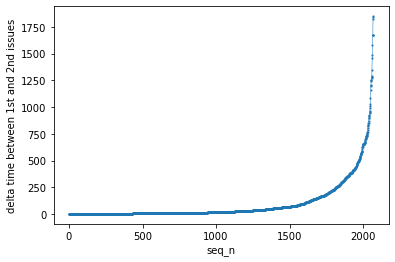

In [29]:
interval = sorted(interval)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.xlabel("seq_n")
plt.ylabel("delta time between 1st and 2nd issues")
ax.plot(range(len(interval)), interval, '-s', linewidth=0.5, markersize=1)

dt = interval[int(len(interval)*0.9)-1]
print(dt) # 90%值

In [72]:
# 去除无法判别为otc或notc的issue-------------------这里还有问题，应该从头到尾重新运行一次
notc = set()
tmp_collect = client.issues.second_issues
for data in tmp_collect.find():
    notc.add(data["owner"]+"/"+data["name"]+"/"+data["resolver"])
    
delete_lst = []
for data in collection1.find():
    if (pd.to_datetime("2022-07-01 00:00:00") - data["closed_at"]).days < dt and data["owner"]+"/"+data["name"]+"/"+data["resolver"] not in notc:
        delete_lst.append(DeleteOne(data))
        
res = collection1.bulk_write(delete_lst)

In [70]:
print(len(delete_lst)) 
# 去除了1380/16692 = 2.28% 的数据

0


In [39]:
n_resolver = set()
for data in tmp_collection.find():
    n_resolver.add(data["resolver"])
print(len(n_resolver))

18864


In [56]:
notc_interval = []
for resolver in n_resolver:
    db = tmp_collection.find({"resolver":resolver})
    if db.count() > 1:
        min_t = tmp_collection.find_one({"resolver":resolver})["resolved_at"]
        max_t = min_t
        for item in db:
            min_t = min(min_t, item["resolved_at"])
            max_t = max(max_t, item["resolved_at"])
        notc_interval.append((max_t-min_t).days)


<ipython-input-56-79159e14d325>:4: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if db.count() > 1:


In [53]:
import datetime
(tmp_collection.find_one({"resolver":resolver})["resolved_at"]-datetime.datetime.now()).days

-396

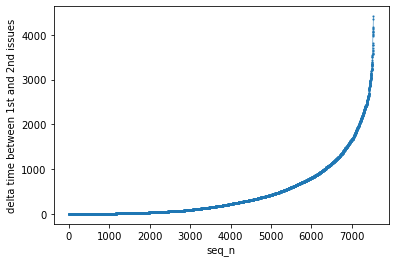

In [57]:
notc_interval = sorted(notc_interval)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.xlabel("seq_n")
plt.ylabel("delta time between 1st and 2nd issues")
ax.plot(range(len(notc_interval)), notc_interval, '-s', linewidth=0.5, markersize=1)

In [58]:
import csv
file = open("../data/notc_interval.csv", 'a+', newline='')
csv_writer = csv.writer(file)
csv_writer.writerow(notc_interval)
file.close()

{'whiskers': [<matplotlib.lines.Line2D at 0x1710c27bfa0>,
 'caps': [<matplotlib.lines.Line2D at 0x1712064ed30>,
 'boxes': [<matplotlib.lines.Line2D at 0x1710c27b250>],
 'medians': [<matplotlib.lines.Line2D at 0x1712064e970>],
 'fliers': [<matplotlib.lines.Line2D at 0x1710a3f7130>],
 'means': []}

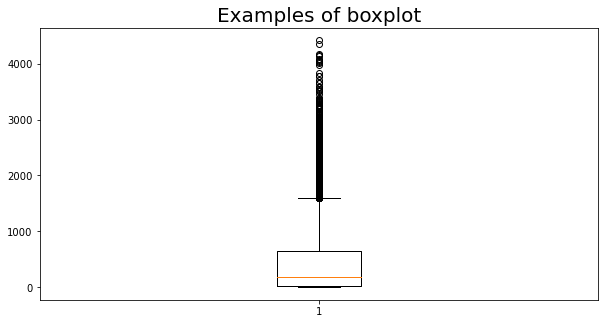

In [60]:
plt.figure(figsize=(10,5))#设置画布的尺寸
plt.title('Examples of boxplot',fontsize=20)#标题，并设定字号大小
# labels = 'Jay'#图例
plt.boxplot(notc_interval)

In [65]:
print(notc_interval.count(0),notc_interval.count(1),notc_interval[len(notc_interval)//10+1],notc_interval[len(notc_interval)//2+1])

447 124 3 183


In [66]:
print(len(notc_interval))

7530


In [68]:
print(notc_interval.index(4))

755
